1. ensure dependencies

In [1]:
import sys
import os
from pathlib import Path

current_dir=str(Path(os.getcwd()).parent.parent)
print(f"Current dir: {current_dir}")
sys.path.insert(0, current_dir)

Current dir: d:\Programming\Python\comfyui-image-scorer


2. main train

In [2]:
import numpy as np
from step03training.full_data.data_utils import (
    load_training_data,
    filter_unused_features,
    add_interaction_features,
    load_training_scores,
)

from shared.paths import vectors_file, scores_file, filtered_data

print("--- Step 1: Loading Data ---")
if not os.path.exists(filtered_data):
    x, y = load_training_data(vectors_file, scores_file)
else:
    x = np.array([])
    y = load_training_scores(scores_file)


print(f"Loaded Data Shape: {x.shape}")

print("\n--- Step 2: Filtering Unused Features ---")
# Removes features with zero variance or zero importance in a quick probe
x, kept_indices = filter_unused_features(x, y)
print(f"Filtered Data Shape: {x.shape}")

print("\n--- Step 3: Generating Interaction Features ---")
# Adds top 500 polynomial interactions (feature_A * feature_B)
x, _ = add_interaction_features(x, y, target_k=200)
print(f"Final Data Shape (with Interactions): {x.shape}")
print("Data Preparation Complete.")

prepare_dir: D:\Programming\Python\comfyui-image-scorer\step02prepare
--- Step 1: Loading Data ---
Loaded Data Shape: (0,)

--- Step 2: Filtering Unused Features ---
Filtering features... Initial shape: (0,)
Loading filtered data from cache: D:\Programming\Python\comfyui-image-scorer\step03training\output\filtered_data.npz
Filtered Data Shape: (11340, 2085)

--- Step 3: Generating Interaction Features ---
Loading interaction data from cache: D:\Programming\Python\comfyui-image-scorer\step03training\output\interaction_data.npz
Final Data Shape (with Interactions): (11340, 2285)
Data Preparation Complete.


Training LightGBM:  66%|██████▌   | 1302/1980 [00:06<00:03, 198.23it/s]


Saved model and diagnostics to: D:\Programming\Python\comfyui-image-scorer\step03training\output\model.npz
Training complete. Evaluation metrics:
  r2: 0.3976
  mae: 0.8088
  mse: 1.0201
  rmse: 1.0100
  model_type: LGBMRegressor
  training_time: 6.5683
  n_iter: 1147.0000
  loss_curve: [np.float64(0.9851152388338229), np.float64(0.9579379025315055), np.float64(0.9359611278984822), np.float64(0.9179751734185483), np.float64(0.9031888145759995), np.float64(0.8895390495279137), np.float64(0.8769944300827356), np.float64(0.8656053228717596), np.float64(0.854659925869497), np.float64(0.8444868772700216), np.float64(0.8382624035608509), np.float64(0.8318751409354344), np.float64(0.8243981454074549), np.float64(0.818490811250945), np.float64(0.8143679684833907), np.float64(0.8103364691670827), np.float64(0.8059689633204007), np.float64(0.801848441126369), np.float64(0.7962602860768191), np.float64(0.7914151457502678), np.float64(0.7870890765015506), np.float64(0.7835599668593548), np.float64

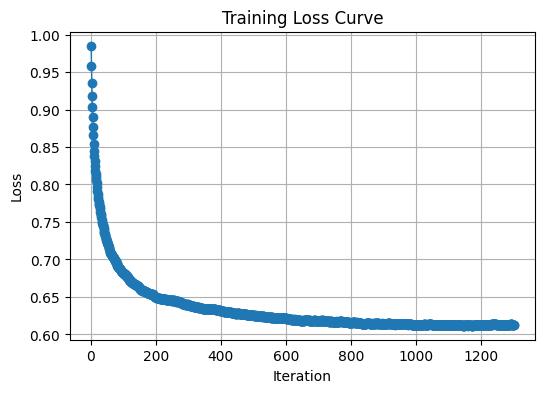

In [3]:
from shared.config import config

import step03training.full_data.run as tr
from step03training.full_data.analysis import plot_loss_curve

from step03training.full_data.model_io import save_model


from shared.paths import training_model

training_cfg = config["training"]

config_selection = "top"

current_config = training_cfg[config_selection]

model, metrics = tr.train_model(
    config_dict=current_config,
    X=x,
    y=y,
    kept_features=kept_indices,
)

score = float(metrics["r2"])
training_time = float(metrics["training_time"])
new_config = {
    **current_config,
    "best_score": score,
    "training_time": training_time,
}
config["training"][config_selection].update(new_config)

save_model(model, training_model, additional_data=metrics)

# Print metrics like run_training did
print("Training complete. Evaluation metrics:")
for k, v in metrics.items():
    try:
        print(f"  {k}: {v:.4f}")
    except Exception:
        print("  {}: {}".format(k, v))

# Friendly post-training suggestion when no diagnostics available
if not metrics.get("has_loss_curve") and not metrics.get("has_n_iter"):
    print(
        "Warning: No training iterations or loss curve were recorded. Consider increasing 'epochs' or using solver='adam' with verbose=True to collect diagnostics."
    )
else:
    plot_loss_curve(training_model, metrics)

In [4]:
import numpy as np
import json

data = np.load(training_model, allow_pickle=True)
print("Saved model diagnostics keys:", list(data.keys()))
if "params" in data:
    raw = data["params"]
    if isinstance(raw, np.ndarray) and raw.shape == ():
        raw = raw.item()
    if isinstance(raw, bytes):
        raw = raw.decode("utf-8")
    if isinstance(raw, str):
        try:
            params = json.loads(raw)
        except Exception:
            try:
                params = eval(raw)
            except Exception:
                params = raw
    else:
        params = raw
    print("  saved params:", params)
# Metrics/loss info may be stored under 'metrics' or top-level keys

metrics_blob = None
if "metrics" in data:
    metrics_blob = data["metrics"]
    try:
        import numpy as _np

        if isinstance(metrics_blob, _np.ndarray) and metrics_blob.shape == ():
            metrics_blob = metrics_blob.item()
    except Exception:
        pass
if (
    metrics_blob is not None
    and isinstance(metrics_blob, dict)
    and "loss_curve" in metrics_blob
):
    lc = np.asarray(metrics_blob["loss_curve"])
    if lc.size > 0:
        print("  loss_curve (first 10):", lc[:10])
    else:
        print("  loss_curve present but empty")
elif "loss_curve" in data:
    lc = np.asarray(data["loss_curve"])
    if lc.size > 0:
        print("  loss_curve (first 10):", lc[:10])

if (
    metrics_blob is not None
    and isinstance(metrics_blob, dict)
    and "n_iter" in metrics_blob
):
    print("  saved n_iter:", int(metrics_blob["n_iter"]))
elif "n_iter" in data:
    print("  saved n_iter:", int(data["n_iter"]))

Saved model diagnostics keys: ['__model_b64__', 'r2', 'mae', 'mse', 'rmse', 'model_type', 'training_time', 'n_iter', 'loss_curve', 'loss_curve_length', 'has_loss_curve', 'has_n_iter']
  loss_curve (first 10): [0.98511524 0.9579379  0.93596113 0.91797517 0.90318881 0.88953905
 0.87699443 0.86560532 0.85465993 0.84448688]
  saved n_iter: 1147


3. compare with real data

Loading trained model from: D:\Programming\Python\comfyui-image-scorer\step03training\output\model.npz
Comparison metrics (sample): r2=0.6789, n=500


d:\Programming\Python\comfyui-image-scorer\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


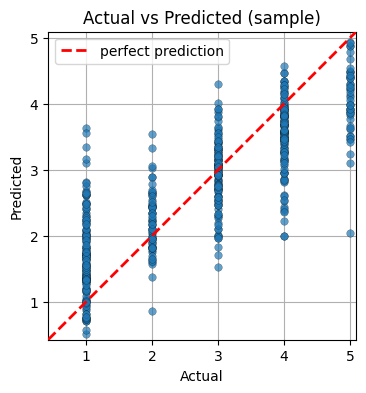

In [5]:
from step03training.full_data.analysis import compare_model_vs_data
compare_model_vs_data(training_model, x, y)